In [190]:
# 📦 Imports
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# 📅 Configurações
plt.rcParams["figure.figsize"] = (12, 6)

In [191]:
from database import FinanceDB

db = FinanceDB()
df = db.get_financas()
accounts = db.get_accounts()

In [192]:
df_expense = df[df["tipo"] == "Gasto"].copy()

df_expense["semana"] = df_expense["data"].dt.to_period("W-MON").dt.start_time
gastos_semanais = -df_expense.groupby("semana")["valor"].sum()
gastos_semanais = gastos_semanais.reset_index()
gastos_semanais.columns = ["ds", "y"]

In [193]:
model = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.05)
model.fit(gastos_semanais)

11:45:17 - cmdstanpy - INFO - Chain [1] start processing
11:45:17 - cmdstanpy - INFO - Chain [1] done processing


In [194]:
future = model.make_future_dataframe(periods=12, freq="W")
forecast = model.predict(future)


In [195]:
comparativo = forecast[["ds", "yhat"]].merge(gastos_semanais, on="ds", how="left")
comparativo["erro"] = comparativo["y"] - comparativo["yhat"]
comparativo.set_index("ds", inplace=True)

In [196]:
q1 = comparativo["erro"].quantile(0.25)
q3 = comparativo["erro"].quantile(0.75)
iqr = q3 - q1
lim_inf = q1 - 1.5 * iqr
lim_sup = q3 + 1.5 * iqr

anomalies = comparativo[(comparativo["erro"] < lim_inf) | (comparativo["erro"] > lim_sup)]

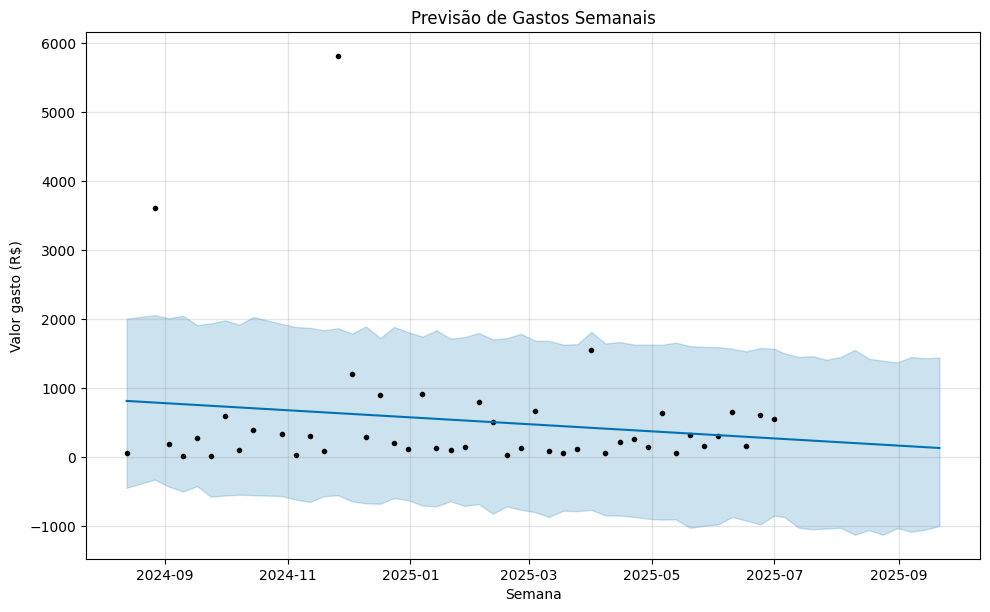

In [197]:
fig = model.plot(forecast)
plt.title("Previsão de Gastos Semanais")
plt.xlabel("Semana")
plt.ylabel("Valor gasto (R$)")
plt.grid(True)
plt.show()


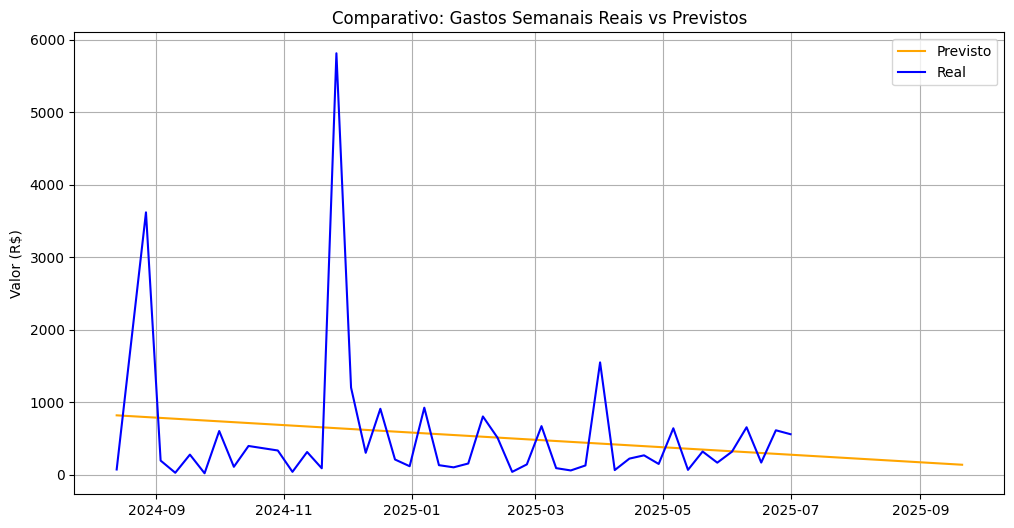

In [198]:
comparativo = forecast[["ds", "yhat"]].merge(gastos_semanais, on="ds", how="left")
comparativo.set_index("ds", inplace=True)

plt.plot(comparativo.index, comparativo["yhat"], label="Previsto", color="orange")
plt.plot(comparativo.index, comparativo["y"], label="Real", color="blue")
plt.legend()
plt.title("Comparativo: Gastos Semanais Reais vs Previstos")
plt.ylabel("Valor (R$)")
plt.grid(True)
plt.show()


In [199]:
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(12)


,ds,yhat,yhat_lower,yhat_upper
45,2025-07-06,265.669416,-865.388860,1506.708271
46,2025-07-13,253.860446,-1016.477973,1453.962884
47,2025-07-20,242.051477,-1042.036423,1464.309106
48,2025-07-27,230.242507,-1029.633266,1413.568876
49,2025-08-03,218.433538,-1021.147852,1453.553344
50,2025-08-10,206.624568,-1121.074240,1556.682836
51,2025-08-17,194.815599,-1051.854979,1427.674238
52,2025-08-24,183.006629,-1120.284459,1398.953347
53,2025-08-31,171.197660,-1023.501602,1374.363784
54,2025-09-07,159.388690,-1077.385943,1452.595837


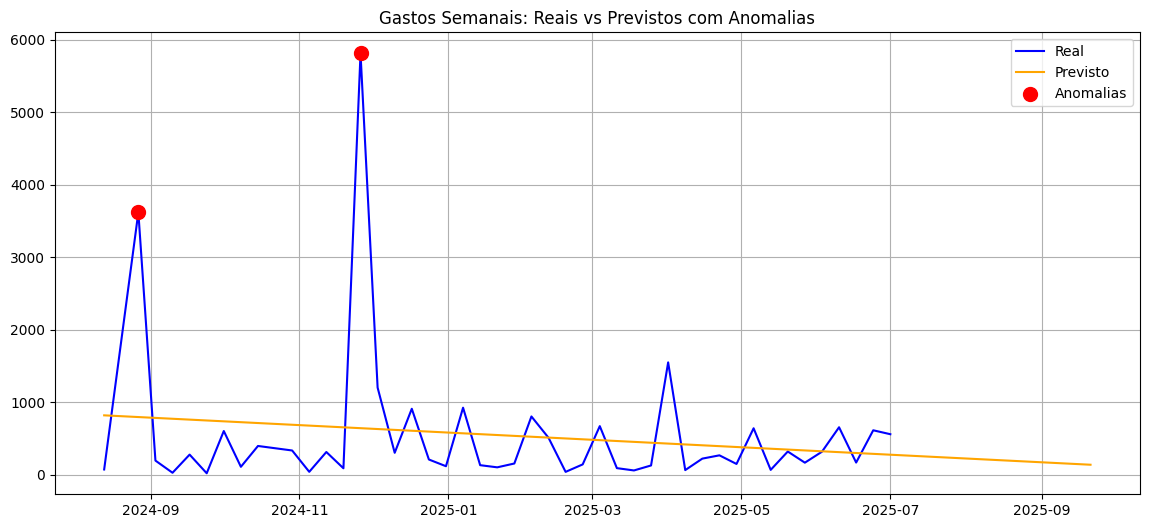

In [200]:
plt.figure(figsize=(14,6))
plt.plot(comparativo.index, comparativo["y"], label="Real", color="blue")
plt.plot(comparativo.index, comparativo["yhat"], label="Previsto", color="orange")
plt.scatter(anomalies.index, anomalies["y"], color="red", label="Anomalias", s=100, zorder=5)
plt.legend()
plt.title("Gastos Semanais: Reais vs Previstos com Anomalias")
plt.grid(True)
plt.show()

In [201]:
anomalies[["y", "yhat", "erro"]].sort_values("erro", key=abs, ascending=False)


,y,yhat,erro
ds,,,
2024-11-26,5812.90,640.182449,5172.717551
2024-08-27,3618.14,793.699053,2824.440947


In [202]:
comparativo["alerta"] = comparativo["y"] > 1.3 * comparativo["yhat"]
comparativo[comparativo["alerta"] == True]

,yhat,y,alerta
ds,,,
2024-08-27,793.699053,3618.14,True
2024-11-26,640.182449,5812.90,True
2024-12-03,628.373479,1199.96,True
2024-12-17,604.755540,907.93,True
2025-01-07,569.328632,922.87,True
2025-02-04,522.092754,801.96,True
2025-03-04,474.856876,668.46,True
2025-04-01,427.620997,1547.79,True
2025-05-06,368.576150,638.90,True


In [203]:
comparativo["excesso"] = comparativo["y"] > comparativo["yhat"] * 1.3
alerta_previsao = comparativo[comparativo["excesso"] == True]

In [204]:
# Preparar base semanal por categoria
df_expense["semana"] = df_expense["data"].dt.to_period("W-MON").dt.start_time
cat_semanal = df_expense.groupby(["semana", "categoria"])["valor"].sum().reset_index()

# Média móvel das 4 últimas semanas
cat_semanal["media_4s"] = cat_semanal.groupby("categoria")["valor"].transform(lambda x: x.shift(1).rolling(4).mean())

# Comparar com semana atual
cat_semanal["crescimento"] = cat_semanal["valor"] > cat_semanal["media_4s"] * 1.5
alerta_categoria = cat_semanal[cat_semanal["crescimento"] == True]


In [205]:
semanas_ordenadas = sorted(df_expense["semana"].unique())[-2:]
semana_atual, semana_passada = semanas_ordenadas

cat_atual = set(df_expense[df_expense["semana"] == semana_atual]["categoria"])
cat_anterior = set(df_expense[df_expense["semana"] == semana_passada]["categoria"])
categorias_novas = cat_atual - cat_anterior

alerta_categoria_nova = df_expense[
    (df_expense["semana"] == semana_atual) & (df_expense["categoria"].isin(categorias_novas))
]